In [1]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Importing Libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import string
from nltk.corpus import stopwords
from tqdm import tqdm

import nltk
from datasets import load_dataset
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from transformers import T5Tokenizer
import torch

from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.optim import Adam

In [5]:
warnings.filterwarnings('ignore')

### Loading Datasets

In [6]:
metaData = load_dataset('wikisql')

Generating test split:   0%|          | 0/15878 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8421 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/56355 [00:00<?, ? examples/s]

In [7]:
metaData

DatasetDict({
    test: Dataset({
        features: ['phase', 'question', 'table', 'sql'],
        num_rows: 15878
    })
    validation: Dataset({
        features: ['phase', 'question', 'table', 'sql'],
        num_rows: 8421
    })
    train: Dataset({
        features: ['phase', 'question', 'table', 'sql'],
        num_rows: 56355
    })
})

In [8]:
trainSampleDataset = []
for each in tqdm(metaData['train']):
    row = { 'question': each['question'], 'sql': each['sql']['human_readable']}
    trainSampleDataset.append(row)
trainDataFrame = pd.DataFrame(trainSampleDataset)

100%|██████████| 56355/56355 [00:27<00:00, 2031.63it/s]


In [9]:
trainDataFrame.head()

,question,sql
0,Tell me what the notes are for South Australia,SELECT Notes FROM table WHERE Current slogan =...
1,What is the current series where the new serie...,SELECT Current series FROM table WHERE Notes =...
2,What is the format for South Australia?,SELECT Format FROM table WHERE State/territory...
3,Name the background colour for the Australian ...,SELECT Text/background colour FROM table WHERE...
4,how many times is the fuel propulsion is cng?,SELECT COUNT Fleet Series (Quantity) FROM tabl...


In [10]:
validationSampleDataset = []
for each in tqdm(metaData['validation']):
    row = { 'question': each['question'], 'sql': each['sql']['human_readable']}
    validationSampleDataset.append(row)
validationDataFrame = pd.DataFrame(validationSampleDataset)

100%|██████████| 8421/8421 [00:01<00:00, 4307.74it/s]


In [11]:
validationDataFrame.head()

,question,sql
0,What position does the player who played for b...,SELECT Position FROM table WHERE School/Club T...
1,How many schools did player number 3 play at?,SELECT COUNT School/Club Team FROM table WHERE...
2,What school did player number 21 play for?,SELECT School/Club Team FROM table WHERE No. = 21
3,Who is the player that wears number 42?,SELECT Player FROM table WHERE No. = 42
4,What player played guard for toronto in 1996-97?,SELECT Player FROM table WHERE Position = Guar...


In [12]:
testSampleDataset = []
for each in tqdm(metaData['test']):
    row = { 'question': each['question'], 'sql': each['sql']['human_readable']}
    testSampleDataset.append(row)
testDataFrame = pd.DataFrame(testSampleDataset)

100%|██████████| 15878/15878 [00:03<00:00, 4091.89it/s]


In [13]:
testDataFrame

,question,sql
0,What is terrence ross' nationality,SELECT Nationality FROM table WHERE Player = T...
1,What clu was in toronto 1995-96,SELECT School/Club Team FROM table WHERE Years...
2,which club was in toronto 2003-06,SELECT School/Club Team FROM table WHERE Years...
3,how many schools or teams had jalen rose,SELECT COUNT School/Club Team FROM table WHERE...
4,Where was Assen held?,SELECT Round FROM table WHERE Circuit = Assen
...,...,...
15873,"After 1972, how many points did Marlboro Team ...",SELECT Points FROM table WHERE Year > 1972 AND...
15874,What chassis had 39 points?,SELECT Chassis FROM table WHERE Points = 39
15875,How many points did the Ford V8 with a Tyrrell...,SELECT Points FROM table WHERE Engine = ford v...
15876,"Before 1976 and with 12 points, what chassis d...",SELECT Chassis FROM table WHERE Engine = ford ...


In [14]:
df = pd.concat([trainDataFrame, validationDataFrame, testDataFrame])

In [15]:
df = trainDataFrame.copy()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56355 entries, 0 to 56354
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  56355 non-null  object
 1   sql       56355 non-null  object
dtypes: object(2)
memory usage: 880.7+ KB


In [17]:
df.isnull().sum()

question    0
sql         0
dtype: int64

### Converting values to lower case

In [18]:
df['question'] = df['question'].str.lower()

In [19]:
df['sql'] = df['sql'].str.lower()

In [20]:
df.head()

,question,sql
0,tell me what the notes are for south australia,select notes from table where current slogan =...
1,what is the current series where the new serie...,select current series from table where notes =...
2,what is the format for south australia?,select format from table where state/territory...
3,name the background colour for the australian ...,select text/background colour from table where...
4,how many times is the fuel propulsion is cng?,select count fleet series (quantity) from tabl...


### Removing Punctuations

In [21]:
def Punctuations(sentence):
    return sentence.translate(str.maketrans('', '', string.punctuation))

In [22]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [23]:
df['question'] = df['question'].apply(Punctuations)

In [24]:
df.head()

,question,sql
0,tell me what the notes are for south australia,select notes from table where current slogan =...
1,what is the current series where the new serie...,select current series from table where notes =...
2,what is the format for south australia,select format from table where state/territory...
3,name the background colour for the australian ...,select text/background colour from table where...
4,how many times is the fuel propulsion is cng,select count fleet series (quantity) from tabl...


### Removing stop words

In [25]:
sql_stopwords = ['SELECT', 'FROM', 'WHERE', 'AND', 'OR', 'NOT', 'AS', 'IN', 'ON', 'JOIN', 'INNER', 'LEFT', 'RIGHT', 'OUTER', 'GROUP', 'BY', 'HAVING', 'ORDER', 'ASC', 'DESC', 'LIMIT', 'OFFSET', 'DISTINCT', 'ALL', 'UNION', 'EXCEPT', 'INTERSECT']
print(f'Number of stop words that are present in sql: {len(sql_stopwords)}')

Number of stop words that are present in sql: 27


In [26]:
for i in range(len(sql_stopwords)):
    sql_stopwords[i] = sql_stopwords[i].lower()

In [27]:
stopWords = stopwords.words('english')
print(f'Number of stop words that are present in english: {len(sql_stopwords)}')

Number of stop words that are present in english: 27


In [28]:
for i in sql_stopwords:
    if i in stopWords:
        stopWords.remove(i)

In [29]:
print(f'Final stopwords list length: {len(stopWords)}')

Final stopwords list length: 168


In [30]:
def stopWordsRemove(sentence):
    finalSentence = ""
    for word in sentence.split():
        if word not in stopWords:
            finalSentence += word + " "
    finalSentence = finalSentence.strip()
    return finalSentence


In [31]:
df['question'] = df['question'].apply(stopWordsRemove)

### Lemmatization

In [32]:
lemma = WordNetLemmatizer()

In [33]:
def lemmatization(text):
    return " ".join([lemma.lemmatize(word, pos = 'n') for word in text.split()])

In [34]:
df['question'] = df['question'].apply(lemmatization)

### Removing Extra Punctuations in SQL

In [35]:
punctuations = string.punctuation
punctuations = punctuations.replace('=', '').replace('(', '').replace(')', '').replace('/', '')

In [36]:
punctuations

'!"#$%&\'*+,-.:;<>?@[\\]^_`{|}~'

In [37]:
def deletePunctuationSQL(sentence):
    for char in punctuations:
        sentence = sentence.replace(char, '')
    return sentence

In [38]:
df['sql'] = df['sql'].apply(deletePunctuationSQL)

### Graph Visualization

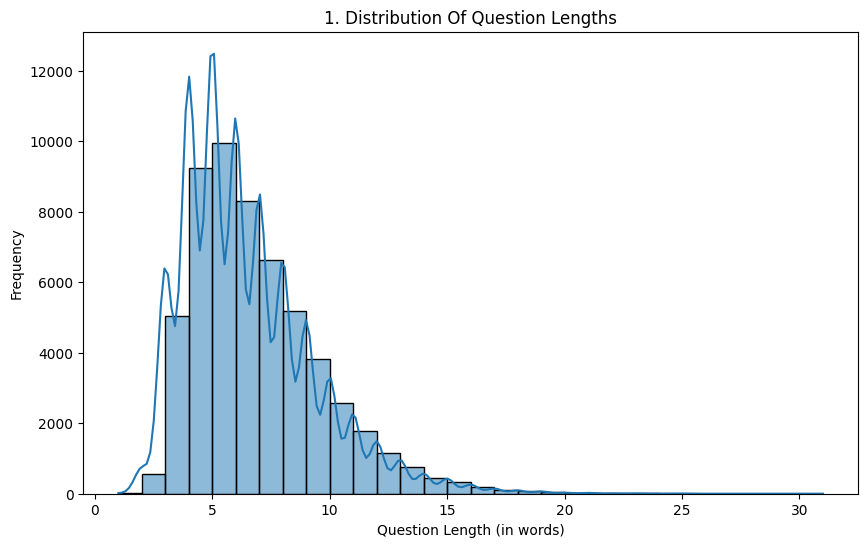

In [39]:
df['questionTokens'] = df['question'].apply(lambda x: len(x.split()))
plt.figure(figsize = (10, 6))

sns.histplot(df['questionTokens'], bins = 30, kde = True)
plt.title('1. Distribution Of Question Lengths')
plt.xlabel('Question Length (in words)')
plt.ylabel('Frequency')
plt.show()

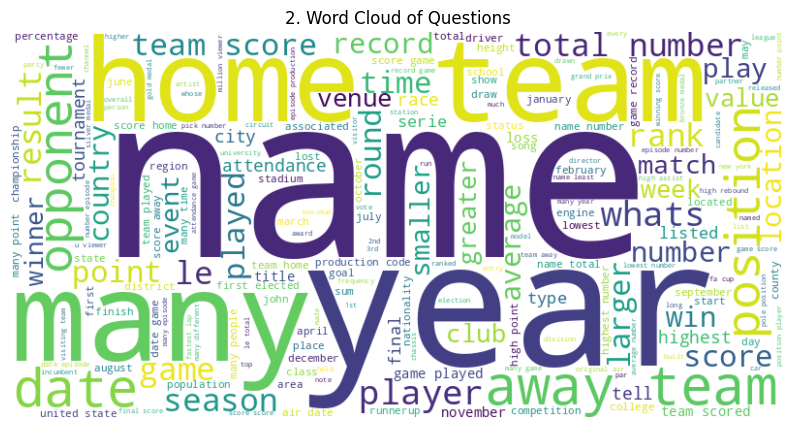

In [40]:
all_questions = ' '.join(df['question'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_questions)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('2. Word Cloud of Questions')
plt.show()


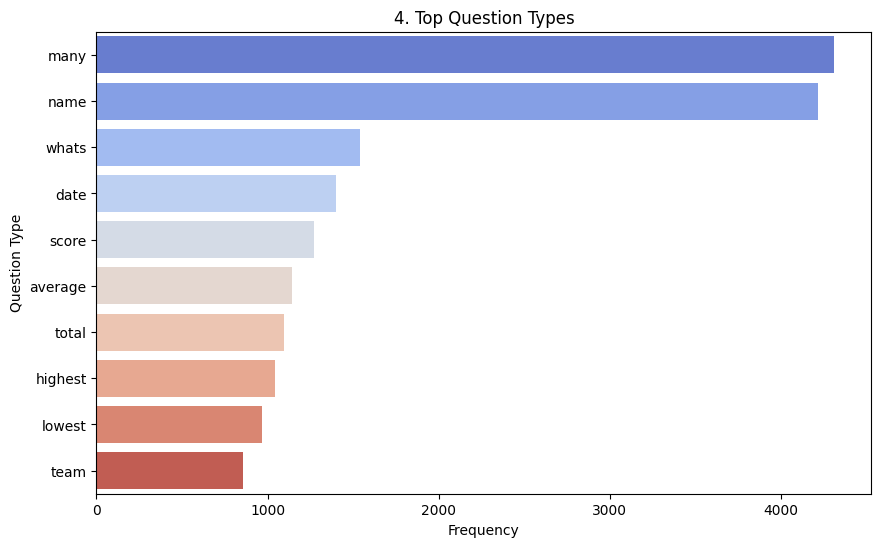

In [41]:
df['questionType'] = df['question'].apply(lambda x: x.split()[0].lower())
question_type_counts = df['questionType'].value_counts().head(10)
question_type_counts = question_type_counts.reset_index()
question_type_counts.columns = ['Question Type', 'Frequency']
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Question Type', data=question_type_counts, palette='coolwarm')
plt.title('4. Top Question Types')
plt.xlabel('Frequency')
plt.ylabel('Question Type')
plt.show()


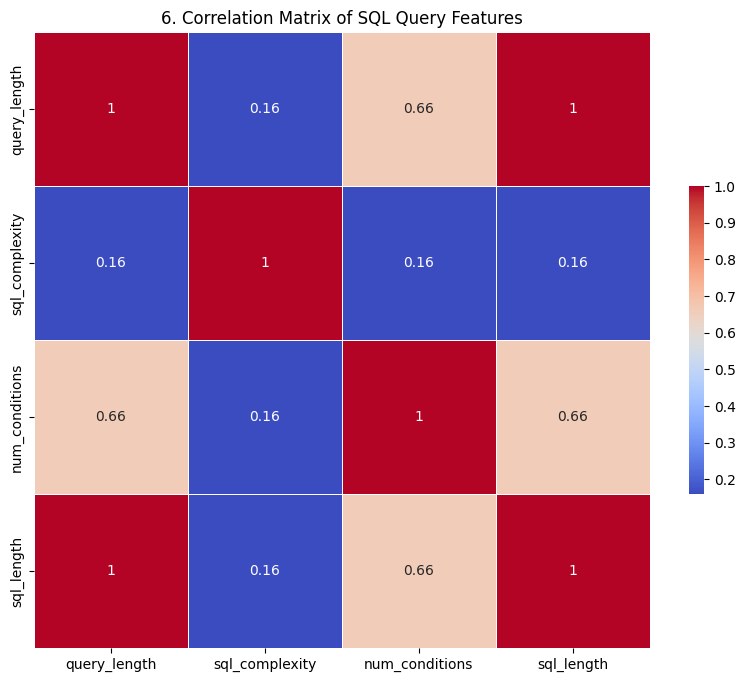

In [42]:
dv=df.copy()

dv['query_length'] = df['sql'].apply(lambda x: len(x.split()))
dv['sql_complexity'] = df['sql'].apply(lambda x: x.upper().count('SELECT') + x.upper().count('WHERE'))
dv['num_conditions'] = df['sql'].apply(lambda x: x.upper().count('AND') + x.upper().count('OR') + 1 if 'WHERE' in x.upper() else 0)
dv['sql_length'] = df['sql'].apply(lambda x: len(x.split()))
corr_matrix = dv[['query_length', 'sql_complexity', 'num_conditions', 'sql_length']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('6. Correlation Matrix of SQL Query Features')
plt.show()



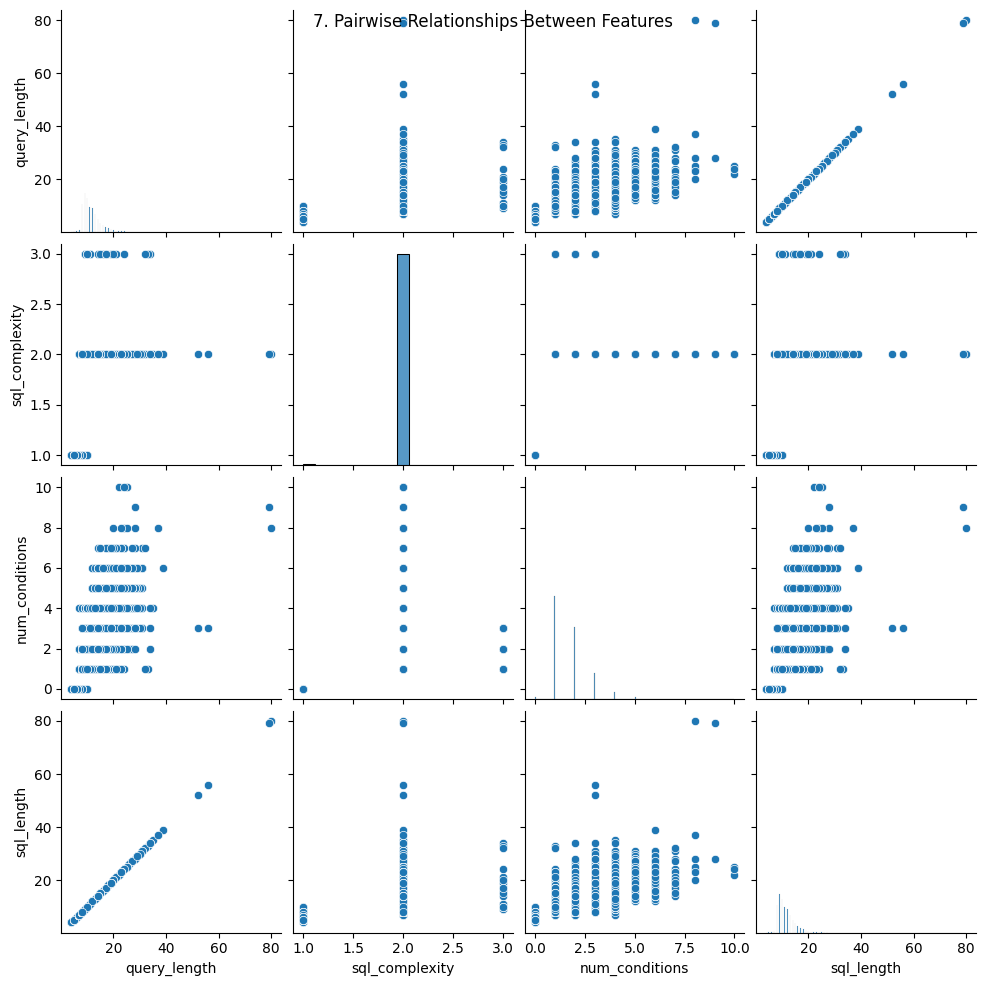

In [43]:
sns.pairplot(dv[['query_length', 'sql_complexity', 'num_conditions', 'sql_length']])
plt.suptitle('7. Pairwise Relationships Between Features', verticalalignment='top')
plt.show()

### Splitting the dataset

In [44]:
X = df['question'].tolist()
y = df['sql'].tolist()

### Checking for GPU

In [45]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained('t5-small')
def tokenize_texts(text_list, max_length=512):
    return tokenizer(
        text_list,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='np'
    )


X_tokenized = tokenize_texts(X)
y_tokenized = tokenize_texts(y)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [46]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_tokenized['input_ids'], y_tokenized['input_ids'], test_size=0.2, random_state=42)


X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [47]:
import tensorflow as tf


gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:

    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:

        print(e)



GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPU


In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Embedding, Concatenate, Attention, Masking
from tensorflow.keras.optimizers import RMSprop


vocab_size = tokenizer.vocab_size
embedding_dim = 256
latent_dim = 512


embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)


encoder_inputs = Input(shape=(None,), dtype='int32', name='encoder_inputs')
encoder_embedded = embedding_layer(encoder_inputs)
encoder_gru = GRU(latent_dim, return_sequences=True, return_state=True, name='encoder_gru')
encoder_outputs, state_h = encoder_gru(encoder_embedded)


decoder_inputs = Input(shape=(None,), dtype='int32', name='decoder_inputs')
decoder_embedded = embedding_layer(decoder_inputs)
decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True, name='decoder_gru')
decoder_outputs, _ = decoder_gru(decoder_embedded, initial_state=state_h)


attention_layer = Attention(name='attention_layer')
attention_result = attention_layer([decoder_outputs, encoder_outputs])


decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])


decoder_dense = Dense(vocab_size, activation='softmax', name='output_layer')
decoder_outputs = decoder_dense(decoder_concat_input)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


model.compile(optimizer=RMSprop(learning_rate=0.001), loss='sparse_categorical_crossentropy')
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 embedding (Embedding)       (None, None, 256)            8192000   ['encoder_inputs[0][0]',      
                                                                     'decoder_inputs[0][0]']  

In [51]:
start_token_id = tokenizer.pad_token_id


decoder_input_data_train = np.hstack([np.full((y_train.shape[0], 1), start_token_id), y_train[:, :-1]])
decoder_input_data_val = np.hstack([np.full((y_val.shape[0], 1), start_token_id), y_val[:, :-1]])


decoder_output_data_train = np.expand_dims(y_train, -1)
decoder_output_data_val = np.expand_dims(y_val, -1)

In [ ]:
history = model.fit(
    [X_train, y_train],
    y_train,
    batch_size=256,
    epochs=10,
    validation_data=([X_val, y_val], y_val)
)


Epoch 1/10
250/250 [==============================] - 603s 2s/step - loss: 0.1411 - val_loss: 0.1299
Epoch 2/10
250/250 [==============================] - 592s 2s/step - loss: 0.1265 - val_loss: 0.1217
Epoch 3/10
250/250 [==============================] - 596s 2s/step - loss: 0.1194 - val_loss: 0.1145
Epoch 4/10
250/250 [==============================] - 599s 2s/step - loss: 0.1148 - val_loss: 0.1113
Epoch 5/10
250/250 [==============================] - 602s 2s/step - loss: 0.1114 - val_loss: 0.1087
Epoch 6/10
250/250 [==============================] - 603s 2s/step - loss: 0.1088 - val_loss: 0.1056
Epoch 7/10
250/250 [==============================] - 617s 2s/step - loss: 0.1063 - val_loss: 0.1036
Epoch 8/10
250/250 [==============================] - 603s 2s/step - loss: 0.1039 - val_loss: 0.1011
Epoch 9/10
250/250 [==============================] - 614s 2s/step - loss: 0.1015 - val_loss: 0.0989
Epoch 10/10
250/250 [==============================] - 599s 2s/step - loss: 0.0992 - val_lo

In [ ]:
test_loss = model.evaluate(
    [X_test, y_test],
    y_test
)

print("Test Loss:", test_loss)


63/63 [==============================] - 25s 401ms/step - loss: 0.0971
Test Loss: 0.09712319076061249


In [ ]:
model.save('my_gru_model.h5')

from tensorflow.keras.models import load_model
loaded_model = load_model('my_gru_model.h5')


In [ ]:
def preprocess_input(sentence, tokenizer, max_length):

    tokenized_input = tokenizer(
        sentence,
        return_tensors='np',
        padding='max_length',
        truncation=True,
        max_length=max_length
    )
    return tokenized_input['input_ids']
def predict_sql(input_sentence, tokenizer, model, max_length):

    input_ids = preprocess_input(input_sentence, tokenizer, max_length)


    start_token_id = tokenizer.pad_token_id
    decoder_input = np.array([[start_token_id]])


    output_tokens = []

    for _ in range(max_length):

        current_pred = model.predict([input_ids, decoder_input])
        next_token_id = np.argmax(current_pred[0, -1, :], axis=-1)


        output_tokens.append(next_token_id)


        decoder_input = np.hstack([decoder_input, [[next_token_id]]])


        if next_token_id == tokenizer.eos_token_id:
            break


    predicted_query = tokenizer.decode(output_tokens, skip_special_tokens=True)
    return predicted_query


In [ ]:
input_sentence = "select score from table."
predicted_sql_query = predict_sql(input_sentence, tokenizer, model, max_length=20)

1/1 [==============================] - 0s 68ms/step


In [ ]:
print("Predicted SQL Query:", predicted_sql_query)

Predicted SQL Query: select min by ( ()))))))))))))))


In [ ]:
train_losses = history.history['loss']
validation_losses = history.history['val_loss']


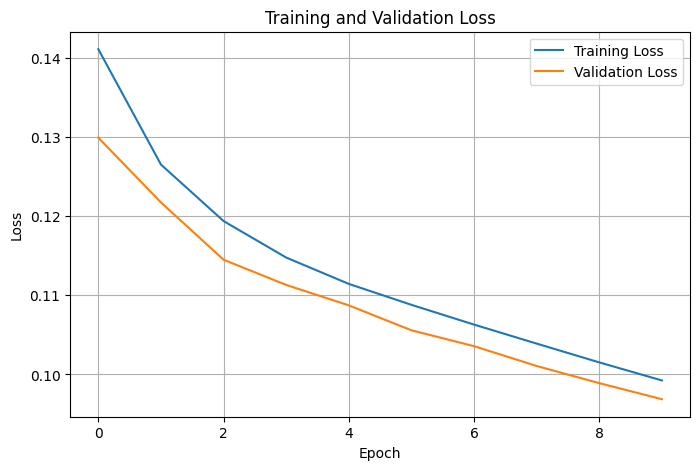

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Optimization Technique 1

In [49]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [53]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1, mode='min')
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
optimizer = RMSprop(learning_rate=0.01, rho=0.9, epsilon=3e-05)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')



history = model.fit(
    [X_train, decoder_input_data_train],
    decoder_output_data_train,
    batch_size=1,
    epochs=30,
    validation_data=(
        [X_val, decoder_input_data_val],
        decoder_output_data_val
    ),
     callbacks=[reduce_lr, early_stopping]
)

Epoch 1/30
800/800 [==============================] - 71s 84ms/step - loss: 0.2133 - val_loss: 0.1535 - lr: 0.0100
Epoch 2/30
800/800 [==============================] - 60s 75ms/step - loss: 0.1444 - val_loss: 0.1441 - lr: 0.0100
Epoch 3/30
800/800 [==============================] - 60s 75ms/step - loss: 0.1357 - val_loss: 0.1409 - lr: 0.0100
Epoch 4/30
800/800 [==============================] - 60s 75ms/step - loss: 0.1299 - val_loss: 0.1345 - lr: 0.0100
Epoch 5/30
800/800 [==============================] - 60s 75ms/step - loss: 0.1250 - val_loss: 0.1335 - lr: 0.0100
Epoch 6/30
800/800 [==============================] - 60s 75ms/step - loss: 0.1212 - val_loss: 0.1316 - lr: 0.0100
Epoch 7/30
800/800 [==============================] - 60s 74ms/step - loss: 0.1178 - val_loss: 0.1293 - lr: 0.0100
Epoch 8/30
800/800 [==============================] - 60s 75ms/step - loss: 0.1146 - val_loss: 0.1278 - lr: 0.0100
Epoch 9/30
800/800 [==============================] - 60s 75ms/step - loss: 0.11

In [56]:
import numpy as np

def predict_sql_query(input_text, tokenizer, model, max_length = 20):
    # Tokenize the input text
    tokenized_input = tokenizer(
        input_text,
        return_tensors='np',
        padding='max_length',
        truncation=True,
        max_length=max_length
    )


    encoder_input = tokenized_input['input_ids']


    initial_decoder_input = np.array([[tokenizer.pad_token_id]]) 


    predicted_sequence = []


    for _ in range(max_length):

        prediction = model.predict([encoder_input, initial_decoder_input])


        predicted_token_id = np.argmax(prediction[0, -1, :])
        predicted_sequence.append(predicted_token_id)


        if predicted_token_id == tokenizer.eos_token_id:
            break


        initial_decoder_input = np.hstack([initial_decoder_input, [[predicted_token_id]]])


    predicted_tokens = tokenizer.convert_ids_to_tokens(predicted_sequence)
    return tokenizer.convert_tokens_to_string(predicted_tokens)


input_text = "what is the age of the girl lucky"
predicted_sql = predict_sql_query(input_text, tokenizer, model)
print(predicted_sql)

1/1 [==============================] - 0s 19ms/step
select select age age age age age good  from bad from table


In [57]:
train_losses = history.history['loss']
validation_losses = history.history['val_loss']

model.save('my_model_GRU_opt1.h5')

In [58]:
decoder_input_data_test = np.hstack([np.full((y_test.shape[0], 1), tokenizer.pad_token_id), y_test[:, :-1]])

decoder_output_data_test = np.expand_dims(y_test, -1)


test_loss = model.evaluate(
    [X_test, decoder_input_data_test],
    decoder_output_data_test
)

print("Test Loss:", test_loss)

4/4 [==============================] - 2s 290ms/step - loss: 0.1168
Test Loss: 0.1167786568403244


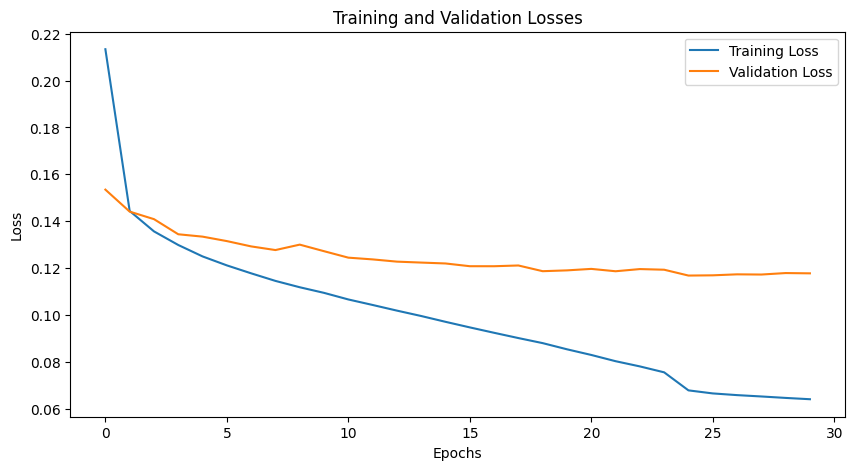

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Optimization Technique 2

In [61]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1, mode='min')
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
optimizer = RMSprop(learning_rate=0.00000001, rho=0.9, epsilon=1e-02)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')



history = model.fit(
    [X_train, decoder_input_data_train],
    decoder_output_data_train,
    batch_size=4,
    epochs=10,
    validation_data=(
        [X_val, decoder_input_data_val],
        decoder_output_data_val
    ),
     callbacks=[reduce_lr, early_stopping]
)

Epoch 1/10
200/200 [==============================] - 44s 205ms/step - loss: 0.0621 - val_loss: 0.1178 - lr: 1.0000e-08
Epoch 2/10
200/200 [==============================] - 39s 196ms/step - loss: 0.0621 - val_loss: 0.1178 - lr: 1.0000e-08
Epoch 3/10
200/200 [==============================] - 39s 196ms/step - loss: 0.0621 - val_loss: 0.1178 - lr: 1.0000e-08
Epoch 4/10
200/200 [==============================] - 39s 196ms/step - loss: 0.0621 - val_loss: 0.1178 - lr: 1.0000e-08
Epoch 5/10
200/200 [==============================] - 38s 192ms/step - loss: 0.0621 - val_loss: 0.1178 - lr: 1.0000e-08
Epoch 6/10
200/200 [==============================] - 39s 196ms/step - loss: 0.0621 - val_loss: 0.1178 - lr: 1.0000e-08
Epoch 7/10
200/200 [==============================] - 38s 191ms/step - loss: 0.0621 - val_loss: 0.1178 - lr: 1.0000e-08
Epoch 8/10
200/200 [==============================] - 38s 191ms/step - loss: 0.0621 - val_loss: 0.1178 - lr: 1.0000e-08
Epoch 9/10
200/200 [====================

In [62]:
import numpy as np

def predict_sql_query(input_text, tokenizer, model, max_length = 20):
    # Tokenize the input text
    tokenized_input = tokenizer(
        input_text,
        return_tensors='np',
        padding='max_length',
        truncation=True,
        max_length=max_length
    )


    encoder_input = tokenized_input['input_ids']


    initial_decoder_input = np.array([[tokenizer.pad_token_id]])  # Start with the start token, adjust as necessary


    predicted_sequence = []


    for _ in range(max_length):

        prediction = model.predict([encoder_input, initial_decoder_input])


        predicted_token_id = np.argmax(prediction[0, -1, :])
        predicted_sequence.append(predicted_token_id)


        if predicted_token_id == tokenizer.eos_token_id:
            break


        initial_decoder_input = np.hstack([initial_decoder_input, [[predicted_token_id]]])


    predicted_tokens = tokenizer.convert_ids_to_tokens(predicted_sequence)
    return tokenizer.convert_tokens_to_string(predicted_tokens)


input_text = "what is the age of the girl lucky"
predicted_sql = predict_sql_query(input_text, tokenizer, model)
print(predicted_sql)

1/1 [==============================] - 0s 80ms/step
select select age age age age age good  from bad from from fromfrom from from from from from from from


In [63]:
decoder_input_data_test = np.hstack([np.full((y_test.shape[0], 1), tokenizer.pad_token_id), y_test[:, :-1]])

decoder_output_data_test = np.expand_dims(y_test, -1)


test_loss = model.evaluate(
    [X_test, decoder_input_data_test],
    decoder_output_data_test
)

print("Test Loss:", test_loss)

4/4 [==============================] - 3s 316ms/step - loss: 0.1168
Test Loss: 0.1167786717414856


In [64]:
train_losses = history.history['loss']
validation_losses = history.history['val_loss']

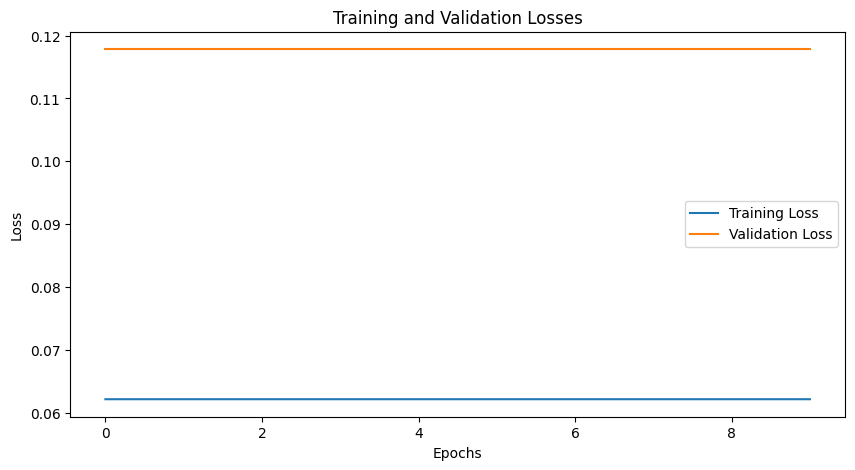

In [65]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()